In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as RMSE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import joblib

In [2]:
FINAL_DATA_PATH = '../data/KS VERI/KS10_FINAL_DATA.csv'

In [3]:
FINAL_DATA_DF = pd.read_csv(FINAL_DATA_PATH)
FINAL_DATA_DF

,Timestamp,PUE,I_KOMP1_HIZ,I_KOMP1_SAAT,I_KOMP2_HIZ,I_KOMP2_SAAT,I_NEM_SET,I_SIC_SET,II_KOMP1_HIZ,II_KOMP1_SAAT,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,2023-04-01 00:10:00,1.634981,25.700001,8968.0,0.0,3.0,45.0,23.0,34.700001,12770.0,...,0,0,1,0,0,0,0,0,0,0
1,2023-04-01 00:15:00,1.608970,28.400000,8968.0,0.0,3.0,45.0,23.0,39.900002,12770.0,...,0,0,1,0,0,0,0,0,0,0
2,2023-04-01 00:20:00,1.554008,28.000000,8968.0,0.0,3.0,45.0,23.0,36.900002,12770.0,...,0,0,1,0,0,0,0,0,0,0
3,2023-04-01 00:25:00,1.640494,30.900000,8968.0,0.0,3.0,45.0,23.0,38.500000,12770.0,...,0,0,1,0,0,0,0,0,0,0
4,2023-04-01 00:30:00,1.590494,25.000000,8968.0,0.0,3.0,45.0,23.0,38.500000,12771.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59623,2023-10-25 00:45:00,1.611181,26.400000,13761.0,0.0,3.0,45.0,22.0,0.000000,17241.0,...,0,0,0,0,0,0,0,0,1,0
59624,2023-10-25 00:50:00,1.831158,39.200001,13761.0,0.0,3.0,45.0,22.0,49.700001,17241.0,...,0,0,0,0,0,0,0,0,1,0
59625,2023-10-25 00:55:00,1.627907,44.000000,13761.0,0.0,3.0,45.0,22.0,0.000000,17241.0,...,0,0,0,0,0,0,0,0,1,0
59626,2023-10-25 01:00:00,1.590126,0.000000,13761.0,0.0,3.0,45.0,22.0,29.400000,17241.0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# put all df s to dict
df_dict = {
    'CH1_CIKIS_SIC': FINAL_DATA_DF[['Timestamp', 'CH1_CIKIS_SIC']],
    'CH1_GIRIS_SIC': FINAL_DATA_DF[['Timestamp', 'CH1_GIRIS_SIC']],
    'CH2_CIKIS_SIC': FINAL_DATA_DF[['Timestamp', 'CH2_CIKIS_SIC']],
    'CH2_GIRIS_SIC': FINAL_DATA_DF[['Timestamp', 'CH2_GIRIS_SIC']],
    'CH3_CIKIS_SIC': FINAL_DATA_DF[['Timestamp', 'CH3_CIKIS_SIC']],
    'CH3_GIRIS_SIC': FINAL_DATA_DF[['Timestamp', 'CH3_GIRIS_SIC']],
    'KS10_UDP_TUKETIM': FINAL_DATA_DF[['Timestamp', 'KS10_UDP_TUKETIM']]
}

In [5]:
for key in df_dict.keys():
    df_dict[key]['Timestamp'] = pd.to_datetime(df_dict[key]['Timestamp'])
    df_dict[key] = df_dict[key].set_index('Timestamp')

/var/folders/mt/twk6ky9932jbskz7g_w2xmpw0000gn/T/ipykernel_22738/1524680169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[key]['Timestamp'] = pd.to_datetime(df_dict[key]['Timestamp'])
/var/folders/mt/twk6ky9932jbskz7g_w2xmpw0000gn/T/ipykernel_22738/1524680169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[key]['Timestamp'] = pd.to_datetime(df_dict[key]['Timestamp'])
/var/folders/mt/twk6ky9932jbskz7g_w2xmpw0000gn/T/ipykernel_22738/1524680169.py:2: SettingWithCopyWarning: 
A value i

In [6]:
def ACF_PACF_PLOT(DATAFRAME):
    fig, axes = plt.subplots(1, 2, figsize=(16,3))
    plot_acf(DATAFRAME, lags=[i for i in range(1, 25)], ax=axes[0])
    plot_pacf(DATAFRAME, lags=[i for i in range(1, 25)], ax=axes[1])
    for ax in axes.flat:
        ax.set_xticks([i for i in range(1, 24)])
    plt.show()

In [7]:
def ARIMA_MODEL(DATAFRAME, order=(1, 0, 0),
                model_save=False):
            
    TRAIN_PERCENT = 0.8
    TRAIN = DATAFRAME.iloc[:int(len(DATAFRAME)*TRAIN_PERCENT)]
    TEST = DATAFRAME.iloc[int(len(DATAFRAME)*TRAIN_PERCENT):]
    
    MODEL = ARIMA(TRAIN, order=order)
    MODEL_FIT = MODEL.fit()
    
    # save model in pickle
    if model_save:
        MODEL_FIT.save('../MHs/pickles/ARIMA_{}_MODEL.pkl'.format(DATAFRAME.columns[0]))
    
    TRAIN_PRED = MODEL_FIT.predict(start=1, end=len(TRAIN))
    TEST_PRED = MODEL_FIT.predict(start=len(TRAIN), end=len(TRAIN)+len(TEST)-1)
    
    '''print('TRAIN_PRED')
    print(TRAIN_PRED)
    print('TEST_PRED')
    print(TEST_PRED)
    #plot TRAIN and TEST
    plt.figure(figsize=(16, 3))
    plt.plot(TRAIN, label='Train')
    plt.plot(TEST, label='Test')
    plt.plot(TRAIN_PRED, label='Train_Pred')
    plt.plot(TEST_PRED, label='Test_Pred')
    plt.legend()
    plt.show()'''
    
    TRAIN_MAPE = MAPE(TRAIN, TRAIN_PRED)
    TEST_MAPE = MAPE(TEST, TEST_PRED)
    TRAIN_RMSE = RMSE(TRAIN, TRAIN_PRED)
    TEST_RMSE = RMSE(TEST, TEST_PRED)
    
    print('ERRORS FOR DATAFRAME: {}'.format(DATAFRAME.columns[0]))
    RESULTS = pd.DataFrame({'MAPE': [TRAIN_MAPE,
                                     TEST_MAPE],
                            'RMSE': [TRAIN_RMSE,
                                     TEST_RMSE]},
                           index=['Train', 'Test'])
    return RESULTS

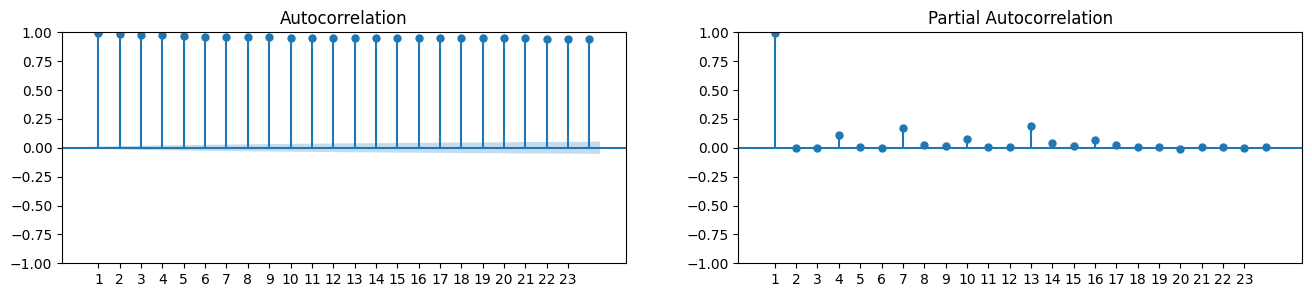

/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


ERRORS FOR DATAFRAME: CH1_CIKIS_SIC


,MAPE,RMSE
Train,0.000332,0.000102
Test,0.073554,4.058981


In [8]:
ACF_PACF_PLOT(df_dict['CH1_CIKIS_SIC'])
ARIMA_MODEL(df_dict['CH1_CIKIS_SIC'], 
            order=(1, 0, 0), 
            model_save=True)

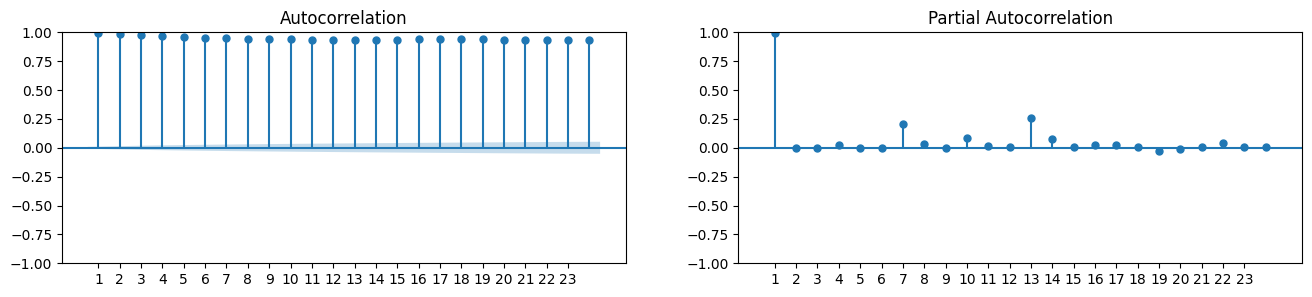

/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


ERRORS FOR DATAFRAME: CH1_GIRIS_SIC


,MAPE,RMSE
Train,0.000319,0.000133
Test,0.048089,2.881864


In [9]:
ACF_PACF_PLOT(df_dict['CH1_GIRIS_SIC'])
ARIMA_MODEL(df_dict['CH1_GIRIS_SIC'],
            order=(1, 0, 0), 
            model_save=True)

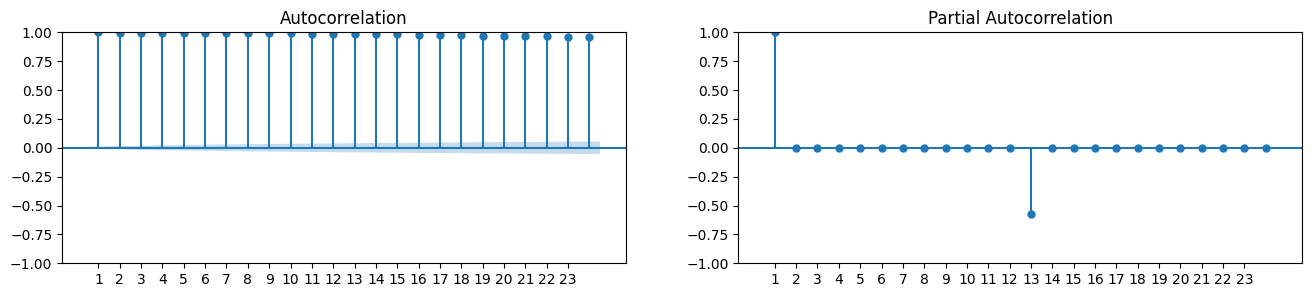

/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


ERRORS FOR DATAFRAME: CH2_CIKIS_SIC


,MAPE,RMSE
Train,0.000289,0.000032
Test,0.167873,13.681117


In [10]:
ACF_PACF_PLOT(df_dict['CH2_CIKIS_SIC'])
ARIMA_MODEL(df_dict['CH2_CIKIS_SIC'],
            order=(1, 0, 0), 
            model_save=True)

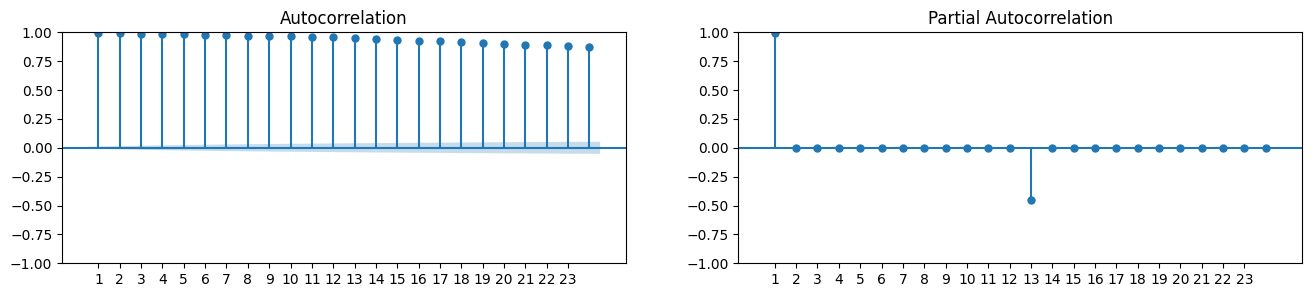

/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


ERRORS FOR DATAFRAME: CH2_GIRIS_SIC


,MAPE,RMSE
Train,0.000802,0.003421
Test,0.212790,248.187404


In [11]:
ACF_PACF_PLOT(df_dict['CH2_GIRIS_SIC'])
ARIMA_MODEL(df_dict['CH2_GIRIS_SIC'],
            order=(1, 0, 0), 
            model_save=True)

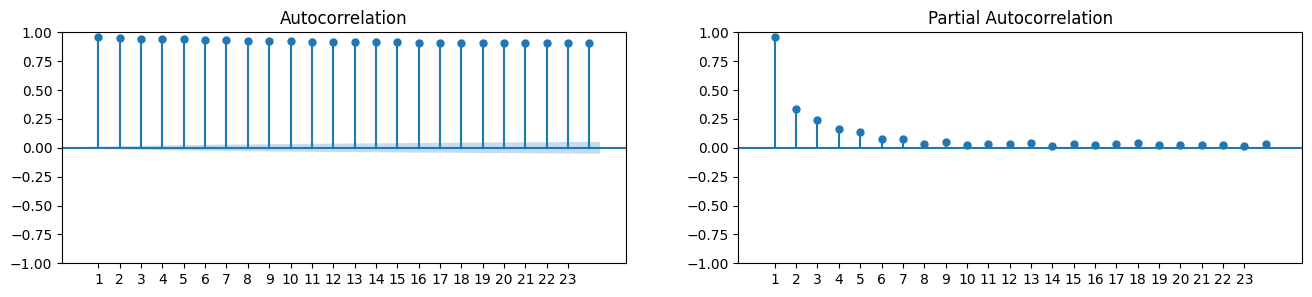

/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


ERRORS FOR DATAFRAME: CH3_CIKIS_SIC


,MAPE,RMSE
Train,0.036614,0.599552
Test,0.053520,1.098957


In [12]:
ACF_PACF_PLOT(df_dict['CH3_CIKIS_SIC'])
ARIMA_MODEL(df_dict['CH3_CIKIS_SIC'],
            order=(0, 0, 1), 
            model_save=True)

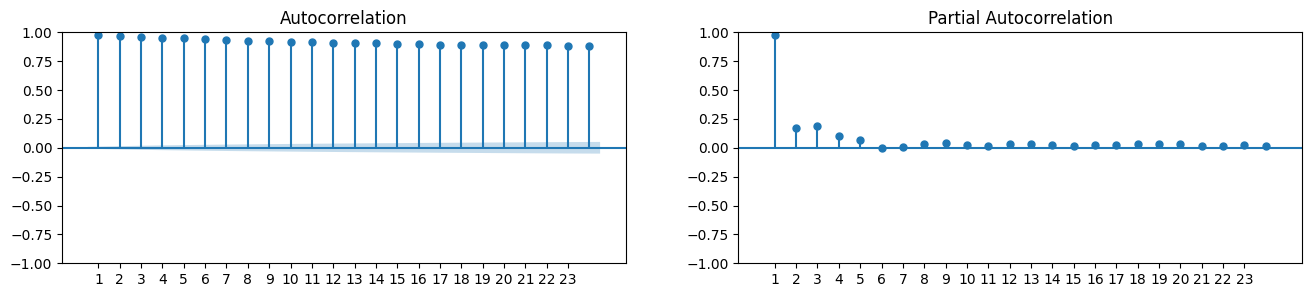

/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


ERRORS FOR DATAFRAME: CH3_GIRIS_SIC


,MAPE,RMSE
Train,0.001166,0.000972
Test,0.028617,0.461774


In [13]:
ACF_PACF_PLOT(df_dict['CH3_GIRIS_SIC'])
ARIMA_MODEL(df_dict['CH3_GIRIS_SIC'],
            order=(2, 0, 0), 
            model_save=True)

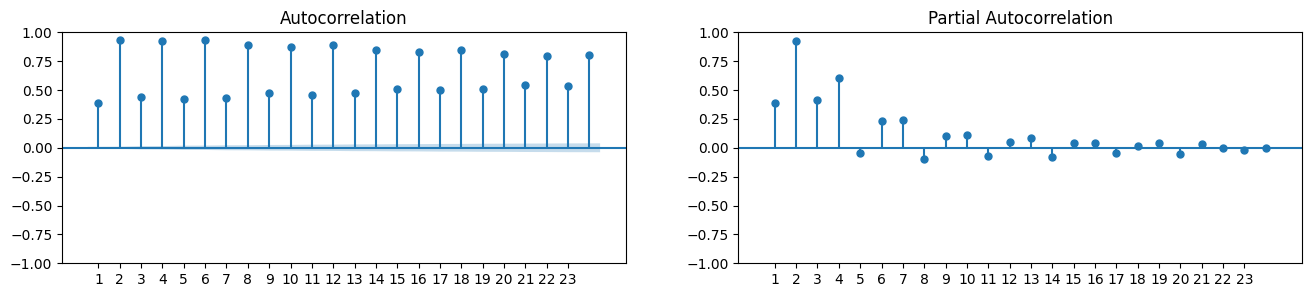

/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/Users/smartopt/Desktop/Bora/Courses/11_Fall'23/INDR 491/code/INDR491/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


ERRORS FOR DATAFRAME: KS10_UDP_TUKETIM


,MAPE,RMSE
Train,0.125004,0.597448
Test,0.231805,0.717785


In [14]:
ACF_PACF_PLOT(df_dict['KS10_UDP_TUKETIM'])
ARIMA_MODEL(df_dict['KS10_UDP_TUKETIM'],
            order=(1, 0, 0), 
            model_save=True)

In [19]:
def arima_predict(model_path, data, pred_start=0, no_pred=1):
    
    if no_pred < 1:
        raise ValueError('no_pred must be greater than 1')
    
    preds = []
    
    model = joblib.load(model_path)
    pred_df = model.predict(start=len(data)+pred_start, end=len(data)+pred_start+no_pred-1)
    for i in range(len(pred_df)):
        preds.append(pred_df.iloc[i])
    
    return preds

In [20]:
arima_predict('../MHs/pickles/ARIMA_CH1_CIKIS_SIC_MODEL.pkl', 
              df_dict['CH1_CIKIS_SIC'][int(len(df_dict['CH1_CIKIS_SIC'])*0.8):],
              pred_start=1,
              no_pred=1)

[23.064280044689752]

In [21]:
df_dict['CH1_CIKIS_SIC']

,CH1_CIKIS_SIC
Timestamp,
2023-04-01 00:10:00,24.1275
2023-04-01 00:15:00,24.1275
2023-04-01 00:20:00,24.1275
2023-04-01 00:25:00,24.7134
2023-04-01 00:30:00,24.7134
...,...
2023-10-25 00:45:00,21.2459
2023-10-25 00:50:00,21.2459
2023-10-25 00:55:00,21.0506
